In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.layers import Dense, concatenate, Input
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
import matplotlib.animation as animation
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer



## Architecture of conditinal GAN


![Conditinal GAN](./demo_image/architecture.png)



In [2]:
PATH = "./CollisionData/"

In [3]:
BUFFER_SIZE = 400
BATCH_SIZE = 128
Z_SIZE = 3
C_SIZE = 3
X_SIZE = 3

In [4]:
def load(file):
    df = pd.read_csv(PATH+'He_300_rough_collision.dat', sep=' ', index_col=0, 
                 names=['time', 'temp', 'c1', 'c2', 'c3', 'x1', 'x2', 'x3'])
    
    input_c = df[['c1', 'c2', 'c3']].values
    input_c[:,2] = np.abs(input_c[:,2])
    output_x = df[['x1', 'x2', 'x3']].values

    input_c = tf.cast(input_c, tf.float32)
    output_x = tf.cast(output_x, tf.float32)

    return input_c, output_x

In [5]:
def density_plot(inp_trans, out_trans, num_first, list_lim):

    fig, axs = plt.subplots(ncols=4, figsize=(20,4))

    for i in range(3):
        sns.kdeplot(inp_trans[:num_first,i], out_trans[:num_first,i],  n_levels=10, 
                    cmap="Blues", shade=True, shade_lowest=False, ax=axs[i])
        sns.regplot(inp_trans[:num_first,i],out_trans[:num_first,i], scatter=False, 
                    color='blue', ax=axs[i])
        axs[i].set_xlim(list_lim[i])
        axs[i].set_ylim(list_lim[i])

    sns.kdeplot(np.sum(inp_trans[:num_first]**2, axis=1), np.sum(out_trans[:num_first]**2, axis=1),  
                n_levels=10, cmap="Blues", shade=True, shade_lowest=False, ax=axs[3])
    sns.regplot(np.sum(inp_trans[:num_first]**2, axis=1), np.sum(out_trans[:num_first]**2, axis=1), 
                scatter=False, color='blue', ax=axs[3])
    axs[3].set_xlim(list_lim[3])
    axs[3].set_ylim(list_lim[3])
    

In [6]:
inp, out = load(PATH+'He_300_rough_collision.dat')
scale = QuantileTransformer(n_quantiles=500, output_distribution='normal')
inp_trans = scale.fit_transform(inp)
out_trans = scale.transform(out)

inp_trans = tf.cast(inp_trans, tf.float32)
out_trans = tf.cast(out_trans, tf.float32)

collision_data = tf.concat([inp, out], axis=1)



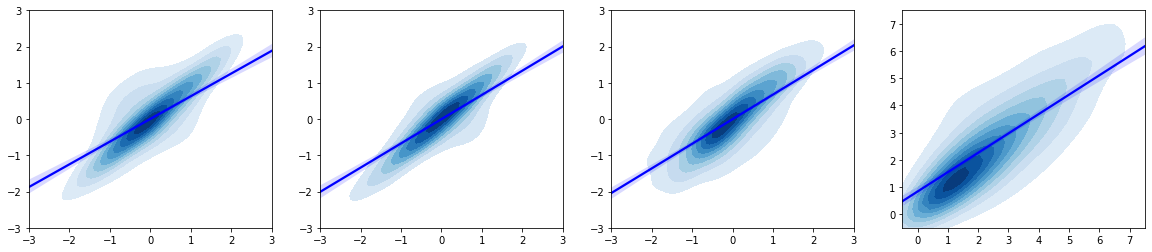

In [7]:
num_first = 1000
list_lim=[[-3,3],[-3,3],[-3,3],[-0.5,7.5]]
density_plot(inp_trans.numpy(), out_trans.numpy(), num_first,list_lim)

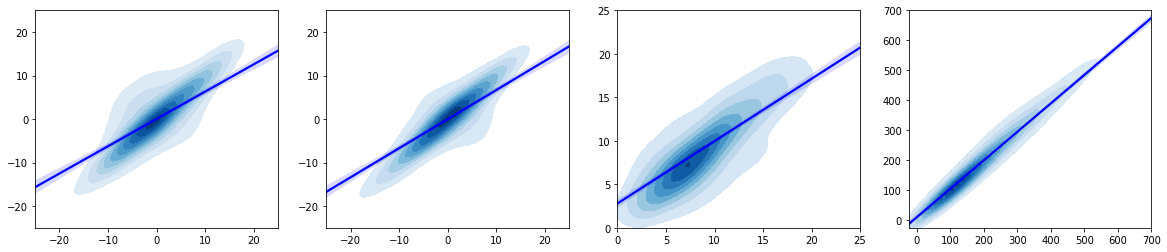

In [8]:
num_first = 1000
list_lim=[[-25,25],[-25,25],[0,25],[-25,700]]
density_plot(inp.numpy(), out.numpy(), num_first,list_lim)

## Generator 
  * The input are 3 conditions c and 3 noise values z.
  * The output are 3 values x
  
## Discriminator
* The input are 3 conditions c and 3 target/G_fake values x.
* The output is one scale value.


In [10]:
noise_dim = 3
condition_dim = 3
gen_dim = 3
initializer = tf.random_normal_initializer(0., 1)

def Generator():
    inp_condition = Input(shape=[condition_dim,], name='condition_G')
    inp_noise = Input(shape=[noise_dim,], name='noise')
    X = concatenate([inp_condition, inp_noise], axis=1)
    
    X = Dense(32, activation='relu')(X)
    X = Dense(32, activation='relu')(X)
    X = Dense(16, activation='relu')(X)
    last = Dense(gen_dim)(X)
    
    return tf.keras.Model(inputs=[inp_condition, inp_noise], outputs=last, name='Generator')

def Discriminator():
    inp_condition = Input(shape=[condition_dim,], name='condition_D')
    inp_target = tf.keras.layers.Input(shape=[gen_dim,], name='target')
    X = concatenate([inp_condition, inp_target], axis=1)
    
    X = Dense(32, activation='relu')(X)
    X = Dense(32, activation='relu')(X)
    X = Dense(16, activation='relu')(X)
    last = Dense(1)(X)
    
    return tf.keras.Model(inputs=[inp_condition, inp_target], outputs=last, name='Discriminator')

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
condition_G (InputLayer)        [(None, 3)]          0                                            
__________________________________________________________________________________________________
noise (InputLayer)              [(None, 3)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 6)            0           condition_G[0][0]                
                                                                 noise[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           224         concatenate[0][0]        

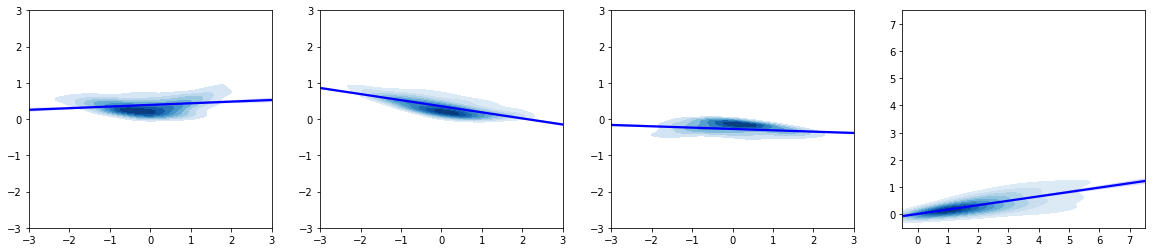

In [11]:
num_test = 1000
generator = Generator()
discriminator = Discriminator()
generator.summary()
discriminator.summary()


noise = tf.random.normal([num_test, noise_dim])
generated_out = generator([noise,noise], training=False)

decision = discriminator([noise,generated_out])

# print(generated_out)
# print(decision)

# Initial plot
list_lim=[[-3,3],[-3,3],[-3,3],[-0.5,7.5]]
density_plot(noise.numpy(), generated_out.numpy(), num_test, list_lim)

## Define the loss and optimizers


In [12]:
lambda_reg = .5

def discriminator_loss(D_real, D_fake, penalty):
    D_loss = tf.reduce_mean(D_fake - D_real + lambda_reg * penalty)
    return D_loss

def generator_loss(D_fake):
    G_loss = -tf.reduce_mean(D_fake)
    return G_loss


In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [14]:
def penalty_calculation(X_real, G_fake, condition):
    # Create the gradient penalty operations.
    epsilon = tf.random.uniform(shape=tf.shape(X_real), minval=0., maxval=1.)
    interpolation = epsilon * X_real + (1 - epsilon) * G_fake
    with tf.GradientTape() as pena_tape:
        pena_tape.watch(interpolation)
        penalty = (tf.norm(
            pena_tape.gradient(discriminator([condition, interpolation]), interpolation),
            axis=1) - 1) ** 2.0
    
    return penalty

### Train discriminator several times in one generator iteration

In [15]:
@tf.function
def train_G(data_batch):
    noise = tf.random.normal([data_batch.shape[0], noise_dim], mean=0.0, stddev=1.0, 
                             dtype=tf.dtypes.float32)
    condition = data_batch[:, :3]
    
    with tf.GradientTape() as gen_tape:        
        G_fake = generator([condition, noise], training=True)
        D_fake = discriminator([condition, G_fake], training=True)
        G_loss = generator_loss(D_fake)

    gradients_of_generator = gen_tape.gradient(G_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return G_loss
    
@tf.function
def train_D(data_batch):
    noise = tf.random.normal([data_batch.shape[0], noise_dim],mean=0.0, stddev=1.0, 
                             dtype=tf.dtypes.float32)
    condition = data_batch[:, :3]
    target = data_batch[:, 3:]
    
    with tf.GradientTape() as disc_tape:
        G_fake = generator([condition, noise], training=True)

        D_real = discriminator([condition, target], training=True)
        D_fake = discriminator([condition, G_fake], training=True)
        penalty = penalty_calculation(target, G_fake, condition)
        D_loss = discriminator_loss(D_real, D_fake, penalty)

    gradients_of_discriminator = disc_tape.gradient(D_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return D_loss


In [16]:
num_first = 10_000
BATCH_SIZE = 1024


train_dataset = tf.data.Dataset.from_tensor_slices(collision_data[:num_first,:]).batch(BATCH_SIZE)

In [17]:
def train(dataset, epochs, D_cycle=1, steps_show=10):
    list_lim=[[-25,25],[-25,25],[0,25],[-25,700]]
    start = time.time()
    figure, ax = plt.subplots(1, 5, figsize=(15, 3))
    figure.suptitle("Generative Adversarial Network Example (WGAN-GP) on Collision Data")
    sns.set(color_codes=True, style='white', palette='colorblind')
    loss_G_train = []
    loss_D_train = []
    for epoch in range(epochs):
        for data_batch in dataset:
            G_loss = train_G(data_batch)
            for _ in range(D_cycle):
                D_loss = train_D(data_batch)
        
        loss_G_train.append(G_loss.numpy())
        loss_D_train.append(D_loss.numpy())
                
        if (epoch+1) % steps_show ==0:   
            num_test = 1000
            condition = collision_data[:num_test, :3]
            noise = tf.random.normal([num_test, noise_dim],mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
            generated_out = generator([condition, noise], training=True)
            
            ### Figure Velocity Density ###
            for i in range(3):
                ax[i].clear()
                ax[i].set_ylim(list_lim[i])
                ax[i].set_xlim(list_lim[i])
                
                plot_data = collision_data.numpy()[:num_test,:]
                ax[i].plot(plot_data[:num_test,i], plot_data[:num_test,i+3], '.b', alpha=.1)
                plot_data = np.concatenate([condition.numpy(), generated_out.numpy()], axis=1)
                ax[i].plot(plot_data[:num_test,i], plot_data[:num_test,i+3], '.r', alpha=.5)
                
                
            ### Figure Energy Density ###
            i=3
            ax[i].clear()
            ax[i].set_ylim(list_lim[i])
            ax[i].set_xlim(list_lim[i])
            
            plot_data = collision_data.numpy()[:num_test,:]
            ax[i].plot(np.sum(plot_data[:num_test,:3]**2, axis=1), 
                       np.sum(plot_data[:num_test,3:]**2, axis=1), '.b', alpha=.1)
            plot_data = np.concatenate([condition.numpy(), generated_out.numpy()], axis=1)
            ax[i].plot(np.sum(plot_data[:num_test,:3]**2, axis=1), 
                       np.sum(plot_data[:num_test,3:]**2, axis=1), '.r', alpha=.5)
            
            ### Figure Discriminator Loss ###
            i=4
            ax[i].clear()
            ax[i].plot([-i for i in loss_D_train], '-')
            ax[i].set_title('Negative critic loss')
            ax[i].set_xlabel('Epoch')
#             ax[i].set_xlim([0, epochs])
            
#             ### Flush ###
            figure.canvas.draw()
            figure.canvas.flush_events()
            plt.pause(0.00001)

#         if (epoch+1 )% 5 ==0: 
#             E_number = str(epoch+1)
#             E_number = '0'*(4-len(E_number)) + E_number
#             figure.savefig(f'./img_ani/img_{E_number}.png', bbox_inches = 'tight', pad_inches=0.3)
            
            
        if (epoch+1 )% 50 ==0:     
            print ('Time for epoch {}/{} is {} sec'.format(epoch+1,epochs, time.time()-start))
            start = time.time()
    figure.show()
    
    return loss_G_train, loss_D_train



In [18]:
%matplotlib qt
loss_G_train, loss_D_train = train(train_dataset, epochs=500, D_cycle=5, steps_show=2)
%matplotlib inline

Time for epoch 50/500 is 26.927300930023193 sec
Time for epoch 100/500 is 23.476265907287598 sec
Time for epoch 150/500 is 23.644884824752808 sec
Time for epoch 200/500 is 24.089345932006836 sec
Time for epoch 250/500 is 23.723145961761475 sec
Time for epoch 300/500 is 24.32999086380005 sec
Time for epoch 350/500 is 23.44443106651306 sec
Time for epoch 400/500 is 23.935258865356445 sec
Time for epoch 450/500 is 23.58510184288025 sec
Time for epoch 500/500 is 23.39648175239563 sec


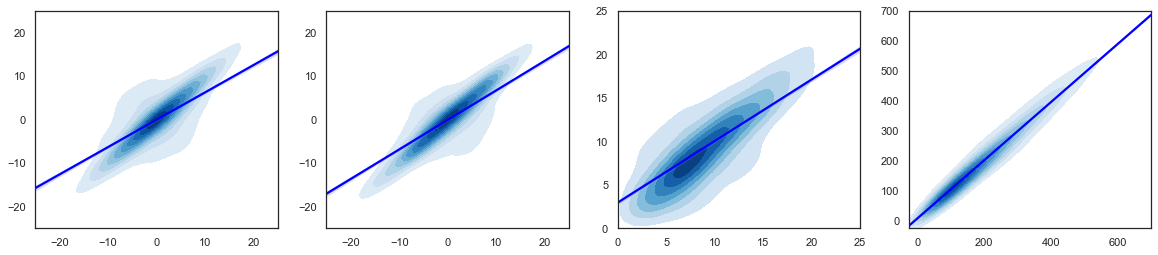

In [19]:
num_first = 5000
# list_lim=[[-1,1],[-1,1],[-1,1],[0,1]]
list_lim=[[-25,25],[-25,25],[0,25],[-25,700]]

plot_data = collision_data[:num_first, :].numpy()
density_plot(plot_data[:,:3], plot_data[:,3:], num_first, list_lim)


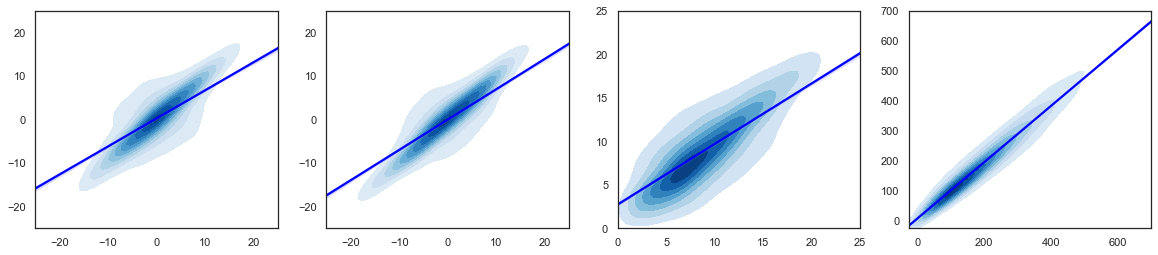

In [20]:
num_test = 5_000
noise = tf.random.normal([num_test, noise_dim])
generated_out = generator([collision_data[:num_test, :3], noise], training=False)
list_lim=[[-25,25],[-25,25],[0,25],[-25,700]]

plot_data = np.concatenate([collision_data.numpy()[:num_test, :3], generated_out.numpy()], axis=1)
density_plot(plot_data[:,:3], plot_data[:,3:], num_test, list_lim)



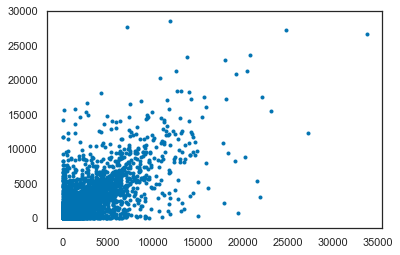

In [21]:
num_first = 5_000
plot_data = collision_data[:num_first, :].numpy()

plt.plot(plot_data[:,2]**3, plot_data[:,5]**3, '.')
# plt.xlim([0,100])

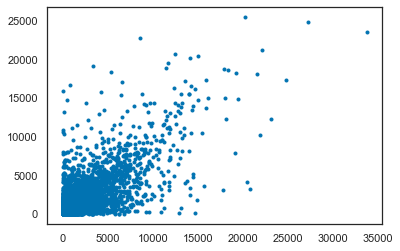

In [22]:
num_test = 5_000
noise = tf.random.normal([num_test, noise_dim])
generated_out = generator([collision_data[:num_test, :3], noise], training=False)

plot_data = np.concatenate([collision_data.numpy()[:num_test, :3], generated_out.numpy()], axis=1)
plt.plot(plot_data[:,2]**3, plot_data[:,5]**3, '.')
# plt.xlim([0,100])